# MSDM5056 Tutorial 8 - Network Models III

## Contents

1. Scale-Free Property
2. The Barabási-Albert Model

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Real networks possess three characteristic properties:

- a scale-free degree distribution $P_k\sim k^{-\gamma}$,
- a high average clustering coefficient $C$, and
- a short average shortest path length $L$.

Models of random networks like the Erdős-Rényi model and small-world networks like the Watts-Strogatz model produce some bell-shaped degree distribution instead of a scale-free one. If we do not not use the configuration model and explicitly specify a network's degree sequence, how can we capture the first feature? More importantly, what does a scale-free degree distribution mean and imply?

---
# 1. Scale-Free Property

A scale-free degree distribution $P(k)$ roughly follows a power law $P(k)\sim k^{-\gamma}$ for some degree exponent $\gamma>0$. It has a very high value for a small $k$ and, theoretically, only vanishes as $k\rightarrow\infty$. This means in that most nodes in a network have a small degree, whereas a few outliers with an exceptionally high degree act as hubs connecting to almost all nodes.

This form of distribution is called "scale-free" for two reasons. Here is the the simpler reason: **a scale-free distribution looks self-similar after you zoom into a particular part.**

\begin{align*}
    P(Ck) \sim \left(Ck\right)^{-\gamma}
           \sim k^{-\gamma}
           \sim P(k)
\end{align*}

In this section, I will use [the collaboration network of a group of physicists from 1995 to 1999](http://www-personal.umich.edu/~mejn/netdata/cond-mat.zip) for demonstration [1].

In [2]:
physics = nx.read_gml('cond-mat/cond-mat.gml')
physics.remove_nodes_from(list(nx.isolates(physics)))

N = physics.number_of_nodes()
E = physics.number_of_edges()
print('N =', N)
print('E =', E)
print('Connectedness =', nx.is_connected(physics))

N = 16264
E = 47594
Connectedness = False


kmin = 1
kmax = 107


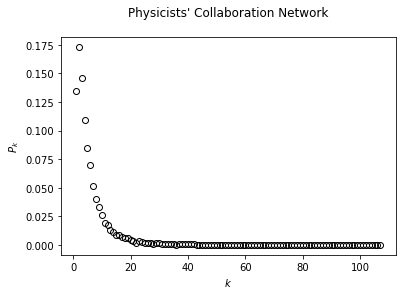

In [3]:
pmf = np.array(nx.degree_histogram(physics)[1:])/N
kDis = np.arange(np.argmax(pmf>0)+1, len(pmf)+1) # DIScrete
kCon = np.linspace(kDis[0], kDis[-1])            # CONtinuous

plt.plot(kDis, pmf, 'ko', mfc='none')
plt.title('Physicists\' Collaboration Network\n')
plt.xlabel('$k$')
plt.ylabel('$P_k$')

print('kmin =', kDis[0])
print('kmax =', kDis[-1])

## 1.1 Visualization

As you see, it is ugly to plot a power law on a linear scale; it is better to plot it on a logarithmic scale instead. However, a log-log plot of $P(k)$ overemphasizes the importance of small-degree nodes—a unit interval on a linear scale, i.e. $\Delta k=1$, spans much wider on the left end than on the right end of a log-log plot. To compensate for the overemphasis, we should logartihmically bin the degree sequences before plotting.

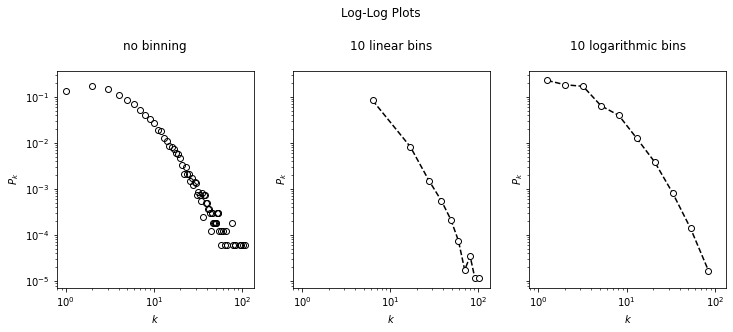

In [4]:
fig, ax = plt.subplots(1, 3, True, True, figsize=(12,4))

cond = pmf > 0
ax[0].loglog(kDis[cond], pmf[cond], 'ko', mfc='none')
ax[0].set_title('no binning\n')

degs = np.array([k for n,k in physics.degree])
pLin, bLin = np.histogram(degs, density=True)
ax[1].loglog((bLin[:-1]+bLin[1:])/2, pLin, 'ko--', mfc='w')
ax[1].set_title('10 linear bins\n')

bLog = np.logspace(*np.log10([kDis[0], kDis[-1]]), 11)
pLog = np.histogram(degs, bLog, density=True)[0]
ax[2].loglog(np.sqrt(bLog[:-1]*bLog[1:]), pLog, 'ko--', mfc='w')
ax[2].set_title('10 logarithmic bins\n')

fig.suptitle('Log-Log Plots', y=1.1)
for a in ax:
    a.set_xlabel('$k$')
    a.set_ylabel('$P_k$')

Better still, as we discussed in Tutorial 4, we may plot the complementary cumulative distribution of a power law instead, i.e. $\overline{C}_k=P\left(X>k\right)$. If $P(k)$ follows a power law $k^{-\gamma}$, $\overline{C}_k$ follows another power law with an exponent equal to $-\gamma+1$.

\begin{align*}
    \overline{C}_k &= \sum_{k+1}^\infty P(k) \\
             &\rightarrow \int_{k}^\infty P{\left(k\right)} dk & \left(\text{assume $k$ continuous}\right) \\
                &\sim \int_{k}^\infty k^{-\gamma} dk \sim k^{-\gamma+1}\,.
\end{align*}

Hereafter the notation $P{\left(k\right)}$ explicitly assumes $k$ continuous. You may wonder if it makes sense to model $k$ as a continuous variable. In fact, when we assume $k$ continuous, we regard $k$ as a node's **expected degree**, which is averaged over a large amount of networks and thus behaves like a real number.

Anyhow, a cumulative distribution can smooth out the random fluctuations in a probability distribution. Because it is always positive, it often behaves nicer than a probability distribution, which may contains zeros, under logarithm.

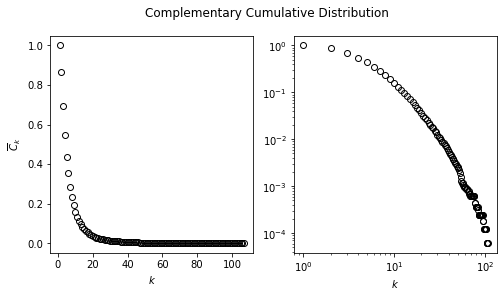

In [5]:
ccmf = np.cumsum(pmf[::-1])[::-1]

fig, ax = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Complementary Cumulative Distribution\n')

ax[0].plot(kDis, ccmf, 'ko', mfc='none')
ax[1].loglog(kDis, ccmf, 'ko', mfc='none')

ax[0].set_ylabel(r'$\overline{C}_k$')
for a in ax:
    a.set_xlabel('$k$')

## 1.2 Measuring degree exponent

The simplest method to estimate the degree exponent of a degree distribution is to plot it (or its CCDF) on a logarithmic scale and to fit it with a straight line, whose slope amounts to $-\gamma$.

\begin{align*}
          P_k \sim k^{-\gamma} \Leftrightarrow
    \ln {P_k} \sim -\gamma \ln {k}
\end{align*}

However, a real degree distribution hardly follows a power law perfectly, so its corresponding log-log plot may deviate much from a straight line. The deviation is especially significant at extreme $k$: real networks cotain much fewer low-degree and high-degree nodes than predicted because of two phenomena.

- **Low-degree saturation.** A power law diverges as $k\rightarrow0$, so it predicts an infinite amount of low-degree nodes, but this is impossible for a finite network.
- **High-degree cutoff.** A power law does not vanish unless $k\rightarrow\infty$, so it predicts the existence of a node with an arbitrarily high degree. This is also impossible as a finite network definitely has a maximum degree.

As a result, the method of fitting suffers huge bias depending on which part of our curve we fit with a straight line.

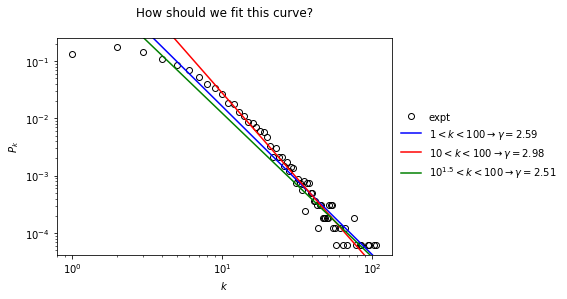

In [6]:
plt.loglog(kDis, pmf, 'ko', mfc='none', label='expt')
plt.xlabel('$k$')
plt.ylabel('$P_k$')
plt.title('How should we fit this curve?\n')
ylim = plt.ylim()

rule1 = (1<kDis) * (kDis<100) * cond
m1,c1 = np.polyfit(np.log(kDis[rule1]), np.log(pmf[rule1]), 1)
plt.plot(kCon, np.exp(c1)*kCon**m1, 'b-',
         label=r'$1<k<100\rightarrow\gamma=%.3g$'%-m1)

rule2 = (10<kDis) * (kDis<100) * cond
m2,c2 = np.polyfit(np.log(kDis[rule2]), np.log(pmf[rule2]), 1)
plt.plot(kCon, np.exp(c2)*kCon**m2, 'r-',
         label=r'$10<k<100\rightarrow\gamma=%.3g$'%-m2)

rule3 = (10**1.5<kDis) * (kDis<100) * cond
m3,c3 = np.polyfit(np.log(kDis[rule3]), np.log(pmf[rule3]), 1)
plt.plot(kCon, np.exp(c3)*kCon**m3, 'g-',
         label=r'$10^{1.5}<k<100\rightarrow\gamma=%.3g$'%-m3)

plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.ylim(ylim)
plt.show()

An alternative and more systematic approach relies on maximum likelihood estimation (MLE). Statistics tells us that $\gamma$ with the following value generates our observed degree sequence $\left\{k_i\right\}$ with the highest probability [2]:

\begin{align*}
    \gamma = 1 + N \left(\sum_{i=1}^N{\ln{\dfrac{k_i}{k_\text{min}+\frac{1}{2}}}}\right)^{-1}
\end{align*}

where $k_\text{min}$ is the minimum degree of the $N$-node network. If $k$ were continuous, the $\dfrac{1}{2}$ in the denominator would not be necessary.

The derivation of the MLE formula assumes that our data follows a power law perfectly. However as we have seen, this is hardly a valid assumption, so a naive application of the formula does not work at all. To yield a more reliable estimate, $k_\text{min}$ should be replaced with some threshold $k^\prime$ above which $P(k)$ indeed follows a power law, and we need some more advanced statistical techniques to optimize $k^\prime$. Check [Barabási's Advanced Topic 4.C](http://networksciencebook.com/chapter/4#advanced-c) if you are interested in the **tedious** procedure [3].

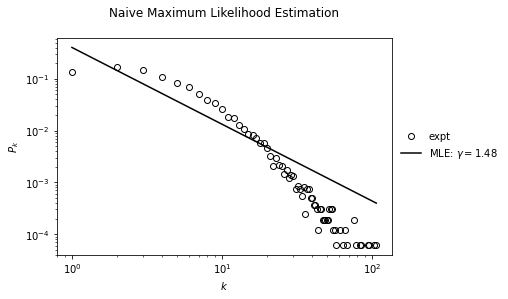

In [7]:
# naive MLE
gMLE = 1 + 1/np.log(degs[degs>=kDis[0]]/(kDis[0]-.5)).mean()
pMLE = kDis**-gMLE / np.sum(kDis**-gMLE)

plt.loglog(kDis, pmf, 'ko', mfc='none', label='expt')
plt.loglog(kDis, pMLE, 'k-', mfc='none', label=r'MLE: $\gamma=%.3g$'%gMLE)
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title('Naive Maximum Likelihood Estimation\n')
plt.xlabel('$k$')
plt.ylabel(r'$P_k$')
plt.show()

## 1.3 Properties

### 1.3.1. Range of degree

Although $k^{-\gamma}$ only vanishes at $k\rightarrow\infty$, a real network definitely has a maximum degree $k_\text{max}$, and we wish to compute its expected value given $P_k$. On average, we allow at most one node with $k>k_\text{max}$, meaning that we need to solve

\begin{align*}
    N \int_{k_\text{max}}^\infty P\left(k\right) dk = 1\,.
\end{align*}

After some algebra, we find that the expected maximum degree depends on the network's minimum degree $k_\text{min}$, which is typically known in advance:

\begin{align*}
    k_\text{max} = k_\text{min} N ^ {\frac{1}{\gamma-1}}\,.
\end{align*}

### 1.3.2. Divergence of moments

The $n^\text{th}$ moment $\langle{k^n\rangle}$ of a scale-free degree distribution integrates, in principle, from $k=0$ to $k\rightarrow\infty$, but practically, we trim the range down to $k\in\left[k_\text{min}, k_\text{max}\right]$ to avoid the improper integral.

\begin{align*}
    \langle{k^n\rangle} &\equiv \int_0^\infty k^n P{\left(k\right)} dk \\
                       &\approx \int_{k_\text{min}}^{k_\text{max}} k^{n-\gamma} dk \\
                          &\sim \dfrac{k_\text{max}^{n-\gamma+1}-k_\text{min}^{n-\gamma+1}}{n-\gamma+1}
\end{align*}

Obviously, $\langle{k^n\rangle}$ diverges when $n=\gamma-1$. Furthermore, although the denominator behaves properly when $n>\gamma-1$, its nominator blows off for a large $N$ because $\dfrac{n}{\gamma-1}-1>0$.

\begin{align*}
      &k_\text{max}^{n-\gamma+1} - k_\text{min}^{n-\gamma+1} \\
    = &k_\text{min}^{n-\gamma+1} N ^ \frac{n-\gamma+1}{\gamma-1} - k_\text{min}^{n-\gamma+1} \\
    = &k_\text{min}^{n-\gamma+1} \left(N^{\frac{n}{\gamma-1}-1}-1\right) \rightarrow \infty
\end{align*}

This leads to the more abstract meaning of "scale-free": **a scale-free distribution lacks well-behaved moments.** What does such divergence imply? A real world network often has $\gamma\in\left[2,3\right]$ and thus a diverging second moment $\langle{k^2\rangle}\rightarrow\infty$. Therefore, while you expect that an arbitrary node from the network has degree $k=\langle{k\rangle}$, you are completely unconfident about your guess as the variance of degree $\sigma_k^2 = \langle{k^2\rangle}-\langle{k\rangle}^2 \rightarrow\infty$.

### 1.3.3. Degree exponent and phase transition

As we have seen, the degree exponent $\gamma$ of a scale-free network determines many of its properties. In fact, the size of $\gamma$ divides scale-free networks into three regimes.

1. **Anomalous regime: $\gamma<2$.** Because $k_\text{max}\sim N^\frac{1}{\gamma-1}$ grows faster than $N$, the corresponding degree distributions can never produce degree sequences for simple graphs but multigraphs. (In other words, the resultant degree seqeucences are not graphical.)
2. **Scale-free regime: $2<\gamma<3$.** Scale-free networks with $\gamma\in\left(2,3\right)$ possess $L\sim\ln{\ln{N}}$, which increases even slower than $\ln{N}$. Therefore scale-free networks are called **ultra-small worlds**.
3. **Random regime: $\gamma>3$.** As $\gamma$ breaks above $3$, the small-world property re-emerges $L\sim\ln{N}$; meanwhile, the probability of an exceptionally high-degree node drops so quickly that the resultant networks almost have no hubs. Scale-free networks with $\gamma>3$ therefore simply look random.

The three regimes bring two critical points, i.e. $\gamma=2$ and $\gamma=3$.

1. At $\gamma=2$, $k_\text{max} \sim N$, which only hold for star-like networks. Consequently, $L$ at $\gamma=2$ is a constant.
2. At $\gamma=3$, a scale-free network possesses $L\sim\dfrac{\ln{N}}{\ln{\ln{N}}}$. In fact, it is undergoing a phase transition and, just like how water and ice coexist at 0°C, is both small and ultra-small.

## 1.4 Forms of power laws

Lastly I will wrap this section up with a statistical detour. Although real networks may contain isolated nodes with $k=0$, we often set an expected minimum degree $k_\text{min}>0$ and assume $k\geq k_\text{min}$.

### 1.4.1. Pure power laws

Practically, a node's degree is an integer, so

\begin{align*}
     P(k) = \dfrac{k^{-\gamma}}{\sum_{k=k_\text{min}}^\infty k^{-\gamma}}
    \equiv \dfrac{k^{-\gamma}}{\zeta\left(\gamma, k_\text{min}\right)}\,.
\end{align*}

Here $\zeta$ denotes Hurwitz's zeta function, which generalizes Riemann's zeta function. This form of power law is often termed the Zipf distribution.

On the other hand, we often assume $k$ continuous for an easier manipulation of algebra and thus obtain a different normalization constant.

\begin{align*}
    P{\left(k\right)} = \dfrac{\gamma-1}{k_\text{min}}\left(\dfrac{k}{k_\text{min}}\right)^{-\gamma}
\end{align*}

This form of power law is termed the Pareto distribution instead.

### 1.4.2. Deviation from power laws

Real networks never follow power laws perfectly. In general, $P(k)$ deviates much from $k^{-\gamma}$ if $k$ is smaller than a saturation degree $k_\text{sat}$ or greather than a cutoff degree $k_\text{cut}$. Various distributions may be used to fit and capture the deviation, e.g.

- power laws with exponential cutoffs $P{\left(k\right)} \sim k^{-\gamma} e^{-\lambda k}$,
- stretched exponential distribution $P{\left(k\right)} = \beta\lambda^\beta k^{\beta-1} e^{−\left(\lambda k\right)^\beta}$, and
- log-normal distribution $P{\left(k\right)} = \dfrac{1}{\sqrt{2\pi}\sigma k} \exp{\left[{-\dfrac{\left(\ln{k}-\mu\right)^2}{2\sigma^2}}\right]}$.

You may read [Barabási's Advanced Topic 4.A](http://networksciencebook.com/chapter/4#advanced-a") for a more detailed discussion on them [3].

---
# 2. The Barabási-Albert Model

In 1999, Barabási and Albert coined the term "scale-free" to describe real networks' degree distributions and first systemically explained their power-law nature with the Barabási-Albert (BA) model [4]. This paper and Watts and Strogatz's paper on small-world networks in 1998 thus jointly opened up a, literally, new millennium for network science.

## 2.1 Algorithm

The model is constructed as follow:

1. Start with an arbitrary $m_0$-node initial graph $G^{\left(0\right)}$ without isolated nodes
2. Iteratively add nodes to the graph until it contains $N$ nodes. 
3. Each newly added node $i$ is connected to $m$ of the existing nodes $j$, and the probability that $i$ connects to $j$ depends on its degree $k_j$ before adding $i$:

\begin{align*}
    p_{ij} = \dfrac{k_j}{\sum_h k_h}\,.
\end{align*}

Barabási and Albert termed this mechanism **preferential attachment** as it is more likely for a higher-degree node to connect to the new node. At time $t$, the network $G^{\left(t\right)}$ has $t$ nodes and $mt$ edges more than the initial configuration $G^{\left(0\right)}$. The choice of $G^{\left(0\right)}$ is trivially significant as long as $N\gg m_0$, while NetworkX's method `barabasi_albert_graph()` builds a BA network on an $m$-node star network. Note that the method always generates a simple BA network.

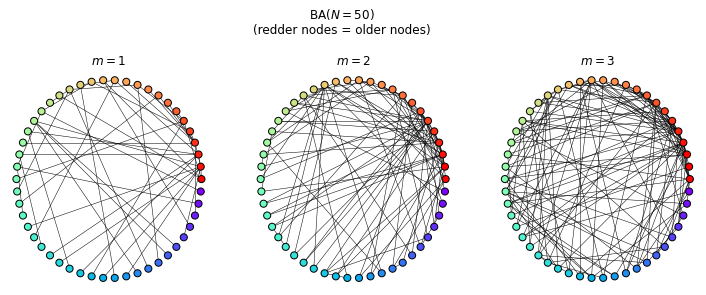

In [8]:
ba = nx.barabasi_albert_graph

N = 50
fig, ax = plt.subplots(1, 3, figsize=(12.4,4))
fig.suptitle(r'$\mathrm{BA}\left(N=%d\right)$'%N + '\n(redder nodes = older nodes)', y=1.1)
for m in [1,2,3]:
    ax[m-1].set_title('$m=%d$' % m)
    nx.draw_circular(ba(N, m, 5056+m), ax=ax[m-1], width=.5,
                     node_size=50, edgecolors='k',
                     node_color = list(range(N)), vmin=m-1, cmap='rainbow_r')

Barabási and Albert in fact defined their model loosely: not only did they not specify $G^{\left(0\right)}$ but also they did not discuss the possibility of self-loops and multi-edges. Such a loose definition in fact hinders us from calculating the model's exact properties exactly, so Bollobás et al. refined Barabási and Albert's definition as the **linearized chord diagram (LCD) model** [5]. Precisely speaking, the LCD model is not a new model but just a possible form of the BA model.

The LCD model starts with $G^{\left(0\right)}$ as a "null graph" and inserts one node with $m$ edges every step until the network contains $N$ nodes. At each step $t$, the model connects nodes $t$ and $u$ with a probability

\begin{align*}
    p_{tu} = \dfrac{k_u + \delta_{tu}}{\sum_{s=1}^t {k_s} + 1} \,,
\end{align*}

where $k$ is a node's degree before adding each new edge $\left(t,u\right)$. While it keeps Barabási and Albert's idea intact, the LCD model is statistically more tractable because it allows the existence of self-loops and multiedges. Remember that $k=0$ initially and each self-loop increases it by $2$.

In [9]:
def lcd(N, m, seed=None, record=False):
    np.random.seed(seed)
    G = nx.MultiGraph()
    k = np.zeros((N,N), dtype=float)
    for t in range(N):
        k[t, :t+1] = np.array([k for n,k in G.degree]+[1])
        for edge in range(m):
            u = np.random.choice(N, 1, p=k[t]/k[t].sum())[0]
            G.add_edge(t, u)
            k[t, t] += 1; k[t, u] += 1
    return (G,k-np.eye(N, dtype=float)) if record else G

## 2.2 Properties

### 2.2.1. Degree distribution

A Barabási-Albert network roughly follows a scale-free degree distribution

\begin{align*}
    P(k) \approx 2 m^2 k^{-3}\,,
\end{align*}

which is not exact because its derivation assumes $k$ continuous. Another important reason lies upon the uncertain topology of $G^\left(0\right)$. If the LCD formulation is used, $P(k)$ can be solved exactly and shown to possess the same form asymptotically:

\begin{align*}
    P(k) = \dfrac{2m\left(m-1\right)}{k\left(k-1\right)\left(k-2\right)}\,.
\end{align*}

This gives us two insights about the significance of the topology of a BA network's $G^{\left(0\right)}$.

1. As $m\gg1$, $m\left(m-1\right)\approx m^2$. Hence if each new node is added with abundant edges, the finite amount of edges of $G^{\left(0\right)}$ hardly contributes to any node's degree and thus $P(k)$.
2. As $N\rightarrow\infty$, nodes with $k\gg1$ naturally emerge and lead to $k\left(k-1\right)\left(k-2\right)\approx k^3$. Hence if the final BA network is very large, degrees of the limited number of nodes in $G^{\left(0\right)}$ become negligible in $P(k)$.

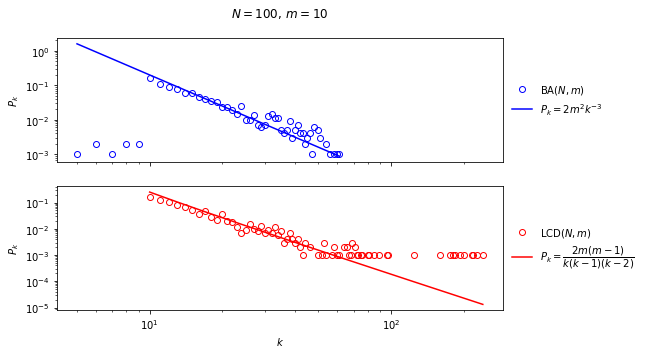

In [10]:
N, m = 100, 10
trials = 10
rBA = [k for t in range(trials) for n,k in ba(N, m, 5056+t).degree]
pBA = np.bincount(rBA) / (N*trials)
kBA = np.arange(np.argmax(pBA>0), len(pBA)).astype(float)
pBA = pBA[int(kBA[0]):]

rLCD = [k for t in range(trials) for n,k in lcd(N, m, 5056+t).degree]
pLCD = np.bincount(rLCD) / (N*trials)
kLCD = np.arange(np.argmax(pLCD>0), len(pLCD)).astype(float)
pLCD = pLCD[int(kLCD[0]):]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5))

ax[0].loglog(kBA, pBA, 'bo', mfc='none', label=r'$\mathrm{BA}(N,m)$')
ax[0].plot(kBA, 2*m**2*kBA**-3, 'b', label='$P_k=2m^2k^{-3}$')
ax[0].legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
ax[0].set_title(r'$N=%d,\,m=%d$' % (N,m)+'\n')

ax[1].loglog(kLCD, pLCD, 'ro', mfc='none', label=r'$\mathrm{LCD}(N,m)$')
ax[1].plot(kLCD, 2*m*(m-1)/kLCD/(kLCD-1)/(kLCD-2), 'r',
           label=r'$P_k=\dfrac{2m(m-1)}{k(k-1)(k-2)}$')
ax[1].legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
ax[1].set_xlabel('$k$')

for a in ax: a.set_ylabel('$P_k$')

### 2.2.2. Degree dynamics

Given a node $i$'s age $a_i$ in a BA network, we can calculate its expected degree $k_i$ as a function of time $t$:

\begin{align*}
    k_i = c_i \left(\dfrac{t}{t-a_i}\right) ^ \frac{1}{2}
   \equiv c_i \left(\dfrac{t}{t_i}\right) ^ \frac{1}{2} \,,
\end{align*}

where $i$ is added to the network at time $t_i$. The proportionality constant $c_i$ equals $k_i{\left(t_i\right)}$ so that the formula is self-consistent. For a simple BA network, nodes outside $G^{\left(0\right)}$ have $c=m$; for a LCD network, $c_i\rightarrow\left(1+\delta_{i0}\right)m$ as $i\gg m$. The formula trivially implies that an older node has a higher degree. Interestingly, if we differentiate the expectation with respect to $t$, we get

\begin{align*}
    \dfrac{dk_i}{dt} \sim \dfrac{1}{{\sqrt{t_i t}}}\,,
\end{align*}

which implies that not only does an older node possess a higher degree but also its degree grows faster than a younger degree's one does.

In fact, if $k_i\sim\left(\dfrac{t}{t_i}\right)^\beta$ for some dynamical exponent $\beta$, the corresponding scale-free network has degree exponent $\gamma=\beta^{-1}+1$.

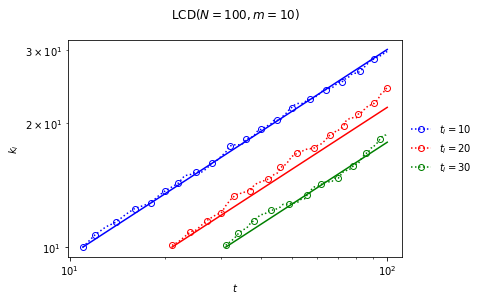

In [11]:
N, m = 100, 10
trials = 10
k = sum(lcd(N, m, 5056+t, True)[1] for t in range(trials))/trials

for i,c in zip([10,20,30], ['b','r','g']):
    t = np.arange(i+1, N+1)
    plt.loglog(t, k[i:,i], c+'o:', mfc='none', markevery=.05, label='$t_i=%d$'%i)
    plt.plot(t, (1+int(i==0))*m*(t/(i+1))**.5, c)
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'$\mathrm{LCD}\left(N=%d,m=%d\right)$'%(N,m)+'\n')
plt.xlabel('$t$')
plt.ylabel('$k_i$')
plt.show()

### 2.2.3. Clustering coefficient

The average clustering coefficient of a BA network with $m>1$ follows [6,7]

\begin{align*}
    C \sim \dfrac{\ln^2 {N}}{N}
\end{align*}

(A BA network with $m=1$ is merely a tree.) If $N\gg m>1$, the prefactor can be solved:

\begin{align*}
C= \dfrac{m}{4}\dfrac{\ln^2{N}}{N}\,.
\end{align*}

Therefore, a BA network is more clustered than an ER network with the same size, for which $C\sim\dfrac{1}{N}$. On the other hand, it is much less clustered than a WS network and real-world networks.

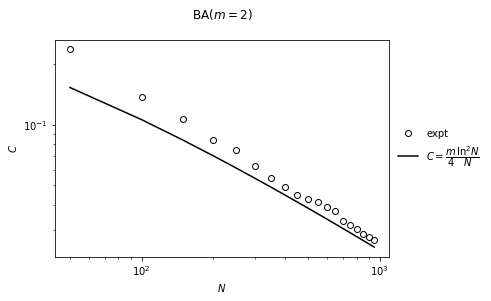

In [12]:
m = 2
trials = 10
Ns = np.arange(0,1000,50)[1:]
Cs = [sum(nx.average_clustering(ba(N,m,5056+t)) for t in range(trials))/trials for N in Ns]
plt.loglog(Ns, Cs, 'ko', mfc='none', label='expt')
plt.plot(Ns, m/4*np.log(Ns)**2/Ns, 'k', label=r'$C=\dfrac{m}{4}\dfrac{\ln^2{N}}{N}$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'$\mathrm{BA}\left(m=2\right)$'+'\n')
plt.xlabel('$N$')
plt.ylabel('$C$')
plt.show()

### 2.2.4. Shortest path length

The average shortest path length of a BA network follows [8,9]

\begin{align*}
    L \sim \dfrac{\ln{N}}{\ln{\ln{N}}}\,,
\end{align*}

which is in general true for any scale-free networks with a degree exponent $\gamma=3$. As Section 1 mentions, this length is shorter than $\ln{N}$ and marks the transition from a small world to an ultra-small world.

However, the scaling relation only holds when $N\rightarrow\infty$, otherwise a BA network expands to a small-world, i.e. $L\sim\ln{N}$ if $N$ is not large enough. Barabási empirically shows that $m=2$ requires $N>10^4$ for a BA network to contract to a ultra-small world [3].

## 2.3 Generalizations

Here I introduce you two interesting generalizations of the Barabási-Albert model.

### 2.3.1. The Bianconi-Barabási model

The Bianconi-Barabási (BB) model amends the edge probability in the BA model to

\begin{align*}
    p_{ij} = \dfrac{\eta_jk_j}{\sum_h \eta_hk_h}\,,
\end{align*}

where $\eta$ measures a node's "fitness" and remains constant over time. The BB model reduces to the BA model if all nodes have the same fitness $\eta=1$.

Bianconi and Barabási particularly studied the case in which $\eta$ follows a fitness distribution $\rho{\left(\eta\right)}\sim(1-\eta)^\xi$ with $\xi>0$. They showed that as $\xi$ grows from $0$ and passes some critical value, a BB network **loses the scale-free topology but becomes star-like**. In other words, the network possesses a bizzare degree distribution:

\begin{align*}
    P_k = \begin{cases}
        \text{very high} & \left(k\rightarrow0\right) \\
        \text{a finite number} & \left(k\rightarrow\infty\right) \\
        0 & \left(\text{otherwise}\right)
    \end{cases}\,.
\end{align*}

In Bianconi and Barabási's original terms, while a scale-free topology emerges due to a **rich-gets-richer** process, a star-like topology emerges due to **winner-takes-all** dynamics.

### 2.3.2. Non-linear preferential attachment

The BA model features linear preferential attachment as $p_{ij}\sim k_j$. In fact, we may replace it with $p_{ij}\sim k^\alpha$, and the size of $\alpha$ yields four regimes.

- **Constant regime $\alpha=0$.** All edges are equally possible, so the resultant network is simply a random network. Its maximum degree $k_\text{max}$ scales with $\ln{t}$.
- **Sublinear regime $0<\alpha<1$.** The resultant network also looks random but contains a few hubs, so its has a higher maximum degree: $k_\text{max}\sim\left(\ln{t}\right)^\frac{1}{1-\alpha}$.
- **Linear regime $\alpha=1$.** The resultant network is an ordinary scale-free BA network with $k_\text{max}\sim t^\frac{1}{\gamma-1}$.
- **Superlinear regime $\alpha>1$**. The resultant network is star-like and obeys $k_\text{max}\sim t$.

## 2.4 Origins of preferential attachment

Although Barábasi and Albert successfully explained real networks' scale-free property with preferential attachment, why should real networks succumb to this rule during its evolution? There are two competiting schools to the answer of this question, viz. the school of randomness and the school of optimization. Although the two schools have opposite philosophies, models from both schools eventually yield preferential attachment, i.e. $p_{ij}\sim k_j$, without explicitly defining edge probability $p_{ij}$.

- **Randomness**

    The school of randomness suggests two mechanisms for the origins of preferential attachment: edge selection and node copying.

    - For edge selection, every new node links to one end of an arbitrary edge. 
    - For node copying, every new node first picks an arbitrary node and then links to it with probability $p$ or any one of its neighbours otherwise.


- **Optimization**

    The school of optimization attributes preferential attachment to some more complex processes. It assumes that a scale-free network possess an intrinsic centre $c$, which is the most important node. Then, every new node $i$ is generated with certain coordinates and gains an edge to node $j$ that minimizes a cost function

    \begin{align*}
    C = \min_j {\left(\delta d_{ij} + d_{0j}\right)}
    \end{align*}

    where $\delta$ is some positive parameter. The interplay between $\delta$ and the network's size $N$ determines if the network is scale-free, star-like, or random.

---
# References

1. Newman M. E. J.: The structure of scientific collaboration networks. Proc. Natl. Acad. Sci. USA, 98(2), 404–409 (2001).
2. Clauset A., Shalizi C. R., Newman M. E. J.: Power-law distributions in empirical data. SIAM Review, 51(4), 661–703 (2009).
3. Barabási A.-L.: Network Science. Cambridge University Press, Cambridge (2016).
4. Barabási A.-L., Albert R.: Emergence of Scaling in Random Networks. Science, 286(5439), 509–512 (1999).
5. Bollobás B., Riordan O., Spencer J., Tusnády G.: The degree sequence of a scale-free random graph process. Random Structures and Algorithms, 18(3), 279–290 (2001).
6. Bollobás B., Riordan O. M,: Mathematical results on scale-free random graphs. In: Bormholdt S., Schuster A. G. (eds.) Handbook of Graphs and Networks, pp. 1–34. Wiley, New York (2003).
7. Klemm K., Eguluz V. M.: Growing scale-free networks with small-world behavior. Phys. Rev. E, 65(5), 057102 (2002).
8. Cohen R., Havlin S.: Scale-free networks are ultra small. Phys. Rev. Lett., 90(5), 058701 (2003).
9. Bollobás B., Riordan O. M.: The diameter of a scale-free random graph. Combinatorica, 24(1), 5–34 (2004).
10. Bianconi G., Barabási. A.-L.: Competition and multiscaling in evolving networks. EPL, 54(4), 436–442 (2001).